# Validate Classification Assignment

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

In [11]:
!pip install mlxtend

In [12]:
!pip install yellowbrick

    100% |████████████████████████████████| 12.6MB 2.3MB/s 
  Found existing installation: matplotlib 3.0.2
    Uninstalling matplotlib-3.0.2:
      Successfully uninstalled matplotlib-3.0.2
  [matplotlib, mpl_toolkits]
You must restart the runtime in order to use newly installed versions.


In [0]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       171
           1       0.40      0.07      0.12        29

   micro avg       0.85      0.85      0.85       200
   macro avg       0.63      0.53      0.52       200
weighted avg       0.79      0.85      0.80       200

accuracy 0.85


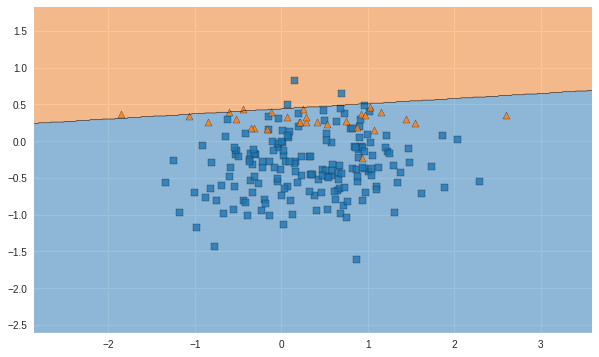

In [38]:
# Try re-running the cell with different values for these parameters
n_samples = 2000
weights = (0.89, 0.11)
class_sep = 0.3

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=2,
                          n_clusters_per_class=1, weights=weights,
                          class_sep=class_sep, random_state=0)

# Split data using custom function above
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)

# Try re-running the cell with different values for this parameter
class_weight = .8

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))

# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0); # decision region plot is not commonly used

(2000, 2)

In [20]:
# precision of blue
(168)/195

0.8615384615384616

In [21]:
#precision of orange
2/(3+2)

0.4

In [22]:
#recall blue
168/171

0.9824561403508771

In [23]:
#recall orange
2/29

0.06896551724137931

In [25]:
# f1 blue
# f1 = 2 x (precision x recall) / (precision + recall)
2*(((168)/195) * (168/171)) / (((168)/195) + (168/171))

0.9180327868852458

In [26]:
# f1 orange
2*((2/(3+2))*(2/29)) / ((2/(3+2))+(2/29))

0.1176470588235294

In [27]:
X

array([[ 0.65064432, -0.62862595],
       [ 0.41450729, -0.18741663],
       [ 0.52484313,  0.89800102],
       ...,
       [ 0.60787348, -0.05822112],
       [ 0.15307354, -0.10166336],
       [ 1.51206436,  0.66779037]])

In [28]:
pd.DataFrame(X, columns=['Feat 1', 'Feat 2'])

,Feat 1,Feat 2
0,0.650644,-0.628626
1,0.414507,-0.187417
2,0.524843,0.898001
3,0.320855,-0.869569
4,0.754801,-0.124283
5,0.882631,-0.639777
6,0.358447,-0.247442
7,0.773142,0.165841
8,0.386390,-0.756758
9,0.270933,-0.388789


In [29]:
y

array([0, 0, 0, ..., 0, 0, 0])

## Redoing the above from scratch

In [0]:
X_train

In [0]:
# Train data = 80%
X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size=.2)

In [0]:
# Validation data = 10% & Test data = 10%
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=.5)

In [42]:
# Confirm split 80%, 10%, 10%
X.shape, X_train.shape, X_val.shape, X_test.shape

((2000, 2), (1600, 2), (200, 2), (200, 2))

In [0]:
def data_splitter(X, y, perc_test,train_size = .8, shuffle=True):
    
    '''
    test_size is what percentage you want your test + validation size to be
    perc_test is the percentage of test_size you want to split to also have validation data
    the higher perc_test, the higher the test size
    ex: perc_test = 0.8 will make test data 80% of the remaining data from train_size 
    '''
    val_test_size = 1 - train_size   
    
    
    # Train data is final here
    X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size=val_test_size, shuffle=shuffle)
    
    # Splitting according to perc_test to obtain validation & test data
    X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=perc_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
X_train, X_val, X_test, y_train, y_val, y_test = data_splitter(X,y, .75)

In [70]:
X.shape, X_train.shape, X_val.shape, X_test.shape

((2000, 2), (1600, 2), (100, 2), (300, 2))

## Bank Marketing

In [72]:
%cd bank-additional/

/content/bank-additional


In [0]:
bank = pd.read_csv('bank-additional-full.csv', sep=';')

In [77]:
bank.shape

(41188, 21)

In [0]:
X = bank.drop(columns='y')
y = bank['y'] == 'yes'

In [80]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [81]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [82]:
bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Creating baseline

In [0]:
X_train, X_val, X_test, y_train, y_val, y_test = data_splitter(X, y, .5, shuffle=False)

In [78]:
X.shape, X_train.shape, X_val.shape, X_test.shape

((41188, 20), (32950, 20), (4119, 20), (4119, 20))

In [0]:
import numpy as np
X_train_numeric = X_train.select_dtypes(np.number)

In [0]:
X_val_numeric = X_val.select_dtypes(np.number)

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='lbfgs'))

pipeline.fit(X_train_numeric, y_train)
y_pred = pipeline.predict(X_val_numeric)

accuracy_score(y_val, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.7178926924010682

In [89]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.5471906268421868

In [87]:
# using majority class - this is just like guessing all are False
y_val.value_counts(normalize=True)

False    0.696043
True     0.303957
Name: y, dtype: float64

In [0]:
LogisticRegression().X_train

### Going beyond baseline

In [91]:
import category_encoders as ce

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

accuracy_score(y_val, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.721048798252003

#### Using Pandas get_dummies THEN pipeline

In [0]:
X_train_dumb = pd.get_dummies(X_train, drop_first=True)
y_train_dumb = pd.get_dummies(y_train, drop_first=True)
X_val_dumb = pd.get_dummies(X_val, drop_first=True)

In [100]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

pipeline.fit(X_train_dumb, y_train_dumb)
y_pred = pipeline.predict(X_val_dumb)

accuracy_score(y_val, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:331: DataConversionWarning: D

0.7283321194464676

In [106]:
roc_auc_score(y_val, y_pred)

0.6176793098952384

In [107]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[2580,  287],
       [ 832,  420]])

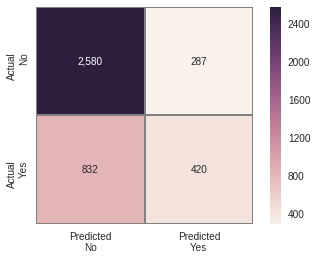

In [112]:
def confusion_viz(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    return sns.heatmap(matrix, annot=True,
                      fmt=',', linewidths=1, linecolor='gray',
                      square=True, xticklabels=['Predicted\nNo', 'Predicted\nYes'],
                      yticklabels=['Actual\nNo', 'Actual\nYes'])

confusion_viz(y_val, y_pred)

In [114]:
# recall score from confusion matrix
from sklearn.metrics import recall_score
recall_score(y_val, y_pred)

0.3354632587859425

In [118]:
287/2580

0.11124031007751937

In [117]:
# precision score from confusion matrix
from sklearn.metrics import precision_score
precision_score(y_val, y_pred)

0.594059405940594